# Stock Selection Machine learning
## Targets: 
1. Train 4 models to achieve the accuracy target
2. Backtesting the models to calculate profits generated both from stock price and dividend yield
3. Consider dividend yield during model training, and make a comparison with the previous results

## 1. Packages imports and initialization

In [1]:
# Basics and visualization
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.pipeline import make_pipeline, Pipeline
import json
from numpy import vstack

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import resample
import os
from sklearn import model_selection

# Models to be considered
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
import torch
from torch import nn
from torch.autograd import Variable
import torchvision
from torchvision.transforms import ToTensor, Lambda
from torch.optim import SGD
from torch.nn.init import xavier_uniform_

# Evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error
from torch.nn import MSELoss
from math import sqrt

# Warning ignorance
import warnings
warnings.filterwarnings("ignore")

c:\Users\asus\anaconda3\envs\pt-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
path = "E:/NUS_Exchange/Research/Datasets/"
try:
    os.mkdir(path + "Output")
    os.mkdir(path + "Data")
    os.mkdir(path + "Output/GridSearchCV_Result")
    os.mkdir(path + "Output/HoldOutValidation")
except:
    print("Folder already exists")

Folder already exists


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Data Processing

In [4]:
# Reading csv files from local repository
def readX(pathname):
    '''
    Read X related file
    '''
    df = pd.read_csv(pathname, index_col=[0], header=[0])
    return df

### 2.1 Data loading

In [5]:
def list_dir(file_dir):
    # list_csv = []
    dir_list = os.listdir(file_dir)
    for cur_file in dir_list:
        path = os.path.join(file_dir,cur_file)
        if os.path.isfile(path):
            # print("{0} : is file!".format(cur_file))
            dir_files = os.path.join(file_dir, cur_file)
        if os.path.splitext(path)[1] == '.csv':
            csv_file = os.path.join(file_dir, cur_file)
            # print(os.path.join(file_dir, cur_file))
            # print(csv_file)
            list_csv.append(csv_file)
        if os.path.isdir(path):
            # print("{0} : is dir".format(cur_file))
            # print(os.path.join(file_dir, cur_file))
            list_dir(path)
    return list_csv
 
 
if __name__ == '__main__':
    paths = r'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering'
    list_csv = []
    list_dir(file_dir=paths)
    print(list_csv)

['E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\AIA.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\ALL.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\AMC.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\ANZ.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\APA.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\ASX.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\BHP.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\BXB.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\CBA.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\COH.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\CPU.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockconsidering\\CSL.AX.csv.csv', 'E:/NUS_Exchange/Research/Datasets/Data/ASX_stockco

### 2.2 Stock price data scaling

### Use one stock as an example

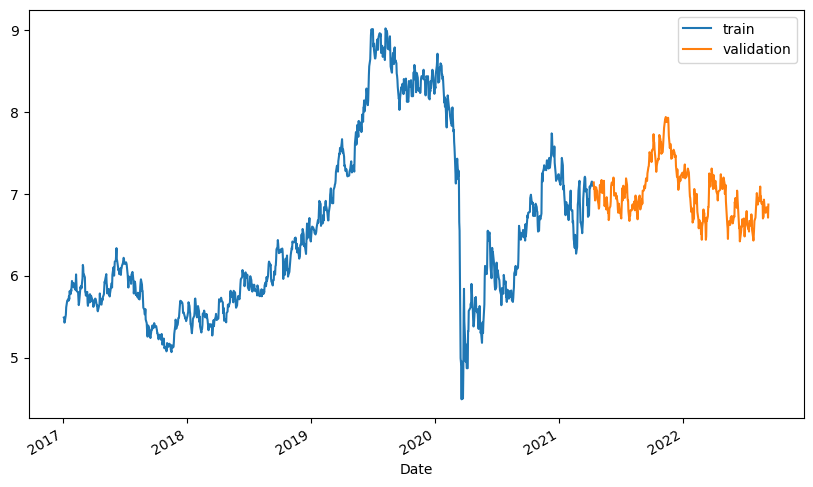

In [6]:
AIA_df = readX(list_csv[0])
AIA_df['Date'] = pd.to_datetime(AIA_df.index)
AIA_df = AIA_df.set_index(['Date'], drop=True)

split_date1 = pd.Timestamp('2017-01-03')
split_date2 = pd.Timestamp('2019-11-05')
split_date3 = pd.Timestamp('2021-04-09')
split_date4 = pd.Timestamp('2021-04-12')
split_date5 = pd.Timestamp('2022-09-08')

TV_AIA_df = AIA_df.loc[split_date1:split_date3]
Test_AIA_df = AIA_df.loc[split_date4:split_date5]

# Didn't include dividend and split
X_train = TV_AIA_df[["Volume", "OpenClose_spread", "Highlow_spread", "5_Days_MA", "10_Days_MA", "15_Days_MA", "30_Days_MA", "5_Days_VAR", "15_Days_VAR", "30_Days_VAR", 
                        "15_Days_EWMA", "15_Days_RSI", "15_Days_MFI", "15_Days_ATR", "ForceIndex", "Typical_MACD"]]
X_train_dividend = TV_AIA_df[["Dividends"]]
X_test = Test_AIA_df[["Volume", "OpenClose_spread", "Highlow_spread", "5_Days_MA", "10_Days_MA", "15_Days_MA", "30_Days_MA", "5_Days_VAR", "15_Days_VAR", "30_Days_VAR", 
                        "15_Days_EWMA", "15_Days_RSI", "15_Days_MFI", "15_Days_ATR", "ForceIndex", "Typical_MACD"]]
X_test_dividend = Test_AIA_df[["Dividends"]]
Y_train = TV_AIA_df[["Price"]]
Y_test = Test_AIA_df[["Price"]]

plt.figure(figsize=(10, 6))
ax = Y_train['Price'].plot()
Y_test['Price'].plot(ax=ax)
plt.legend(['train', 'validation'])

In [7]:
scales = [StandardScaler(), MinMaxScaler(), QuantileTransformer()]

## 3. Test and Criteria

In [8]:
def getScore(pipe_lr, X_valid, y_valid, prob = False):
    '''
    Get ROC
    '''
    y_pred = pipe_lr.predict(X_valid)
    if prob:
        y_pred = pipe_lr.predict_proba(X_valid)[:,1]
    print('ROC: %.4f' % roc_auc_score(y_true=y_valid, y_score=y_pred))

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate mse
    mse = MSE(actuals, predictions)
    return mse

def getPrediction_ANN(predict_dl, model):
    predictions = list()
    for i, (inputs, targets) in enumerate(predict_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        predictions.append(yhat)
    predictions = vstack(predictions)
    
    return pd.DataFrame(data=predictions)



Rolling windows

In [13]:
model_mse = []
Totaldatas = 720
Window = 30
Rollingtimes = 12

def RollingTrain(X_train, Y_train, times, selectedModel, scale):
    X1 = X_train[Window * times : Totaldatas + Window * times].values
    Y1 = Y_train[Window * times : Totaldatas + Window * times].values
    X1_ = X_train[Totaldatas + Window * times : Totaldatas + Window * (times + 1)].values
    Y1_ = Y_train[Totaldatas + Window * times : Totaldatas + Window * (times + 1)].values

    scaler = scale.fit(X1)
    X1_scaled = scaler.transform(X1)
    X1__scaled = scaler.fit_transform(X1_)
    model = selectedModel.fit(X1_scaled, Y1)
    prediction = model.predict(X1__scaled)
    mse = MSE(Y1_, prediction)
    model_mse.append(mse)

def TrainRolling(Rollingtimes, selectedModel, scale):
    for i in range(0, Rollingtimes):
        RollingTrain(X_train, Y_train, i, selectedModel, scale)
    return np.mean(model_mse)


## 4. Random Forest

### 4.1 Parameters to be considered

In [15]:
rf_n_estimators = [50, 100, 300, 500, 800, 1200]
rf_max_depth = [None, 20, 100, 300, 500, 1000]
rf_max_leaf_nodes = [1000, 500, 200, 100]
rf_min_samples_split = [2, 10, 20, 50]


In [14]:
rf_parameters = []
def RandomForestTraining():
    averageMSE = []
    for n_estimators in rf_n_estimators:
        for max_depth in rf_max_depth:
            for max_leaf_nodes in rf_max_leaf_nodes:
                for min_samples_split in rf_min_samples_split:
                    for scaler in scales:
                        rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_leaf_nodes = max_leaf_nodes, min_samples_split = min_samples_split)
                        averageMSE.append(TrainRolling(Rollingtimes, rf, scaler))
                        rf_parameters.append(["rf_n_estimators: ", n_estimators, "; rf_max_depth:", max_depth, "; rf_max_leaf_nodes: ", max_leaf_nodes, "; rf_min_samples_split: ", 
                                             min_samples_split, "; scaler: ", scaler])
    return averageMSE

In [16]:
x = RandomForestTraining()

KeyboardInterrupt: 

## 5. ANN Model Construction

### 4.1 Trial for one index

In [ ]:
batch_size = 128
iteration_num = 100

Using cuda device


In [ ]:
print(np.any(np.isnan(X_train)))
print(np.any(np.isnan(X_test)))
print(np.any(np.isnan(Y_train)))
print(np.any(np.isnan(Y_test)))

# MinMax Scaler
X_train_index = X_train.index
X_validation_index = X_test.index
Y_train_index = Y_train.index
Y_validation_index = Y_test.index


scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation = scaler.fit_transform(X_test)

# For recover purpose, we have the min and max value
Y_train_min = Y_train["Price"].min()
Y_train_max = Y_train["Price"].max()
Y_validation_index = Y_test.index

scaler = scaler.fit(Y_train)
Y_train = scaler.transform(Y_train)
Y_validation = scaler.fit_transform(Y_test)
Y_validation_stored = Y_validation.copy()

# Include the dividend paid now
X_train = np.concatenate((X_train, X_train_dividend.values), axis = 1)
X_validation = np.concatenate((X_validation, X_test_dividend.values), axis = 1)

False
False
False
False


In [ ]:
# Transform double to float
X_train = torch.from_numpy(np.array(X_train.astype(np.float32)))
X_validation = torch.from_numpy(np.array(X_validation.astype(np.float32)))
Y_train = torch.from_numpy(np.array(Y_train.astype(np.float32)))
Y_validation = torch.from_numpy(np.array(Y_validation.astype(np.float32)))

Total_train = torch.utils.data.TensorDataset(X_train, Y_train)
Total_validation = torch.utils.data.TensorDataset(X_validation, Y_validation)

train_loader = torch.utils.data.DataLoader(Total_train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(Total_validation, batch_size=batch_size, shuffle=True)

In [ ]:
# Use relu to be the activation function
class ANNModel(nn.Module):
    def __init__(self, n_inputs):
        super(ANNModel, self).__init__()
		# Layers
        self.hidden1 = nn.Linear(n_inputs, 128)
        xavier_uniform_(self.hidden1.weight)
        self.act1 = nn.Sigmoid()
        # second hidden layer
        self.hidden2 = nn.Linear(n_inputs, 32)
        xavier_uniform_(self.hidden2.weight)
        self.act2 = nn.Sigmoid()
        # third hidden layer and output
        self.hidden3 = nn.Linear(n_inputs, 1)
        xavier_uniform_(self.hidden3.weight)
        
    def forward(self, x):
        # input to first hidden layer
        out = self.hidden1(x)
        out = self.act1(x)
         # second hidden layer
        out = self.hidden2(x)
        out = nn.functional.relu(self.act2(x))
        # third hidden layer and output
        out = self.hidden3(x)
        return out

# train the model
def train_model(train_set, model):
    # define the optimization
    criterion = MSELoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(iteration_num):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_set):
            inputs = inputs
            targets = targets
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [ ]:
ANN_model_trail = ANNModel(16)
train_model(train_loader, ANN_model_trail)
mse = evaluate_model(validation_loader, ANN_model_trail)
print('MSE: %.3f, RMSE: %.3f' % (mse, sqrt(mse)))

MSE: 0.027, RMSE: 0.164


<Figure size 1000x600 with 0 Axes>

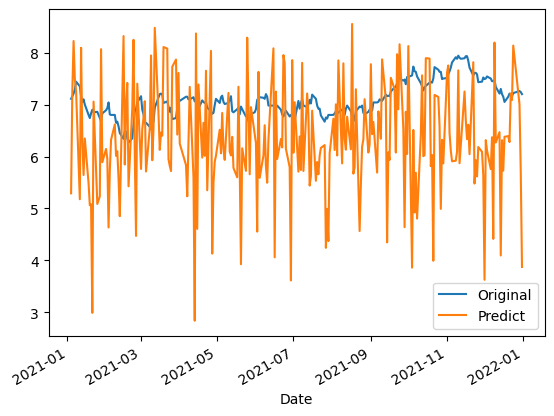

In [ ]:
predictedprice = getPrediction_ANN(validation_loader, ANN_model_trail)
predictedprice[0] = predictedprice[0] * (Y_train_max - Y_train_min) + Y_train_min
predictedprice.index = Y_validation_index

plt.figure(figsize=(10, 6))
ax = Test_AIA_df[["Price"]].plot()
predictedprice.plot(ax=ax)
plt.legend(['Original', 'Predict'])

<Figure size 1000x600 with 0 Axes>

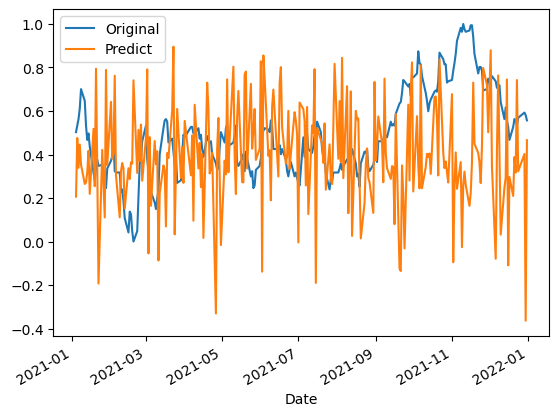

In [ ]:
predictedprice = getPrediction_ANN(validation_loader, ANN_model_trail)
predictedprice.index = Y_validation_index
Y_validation_stored = pd.DataFrame(Y_validation_stored)
Y_validation_stored.index = Y_validation_index

plt.figure(figsize=(10, 6))
ax = Y_validation_stored.plot()
predictedprice.plot(ax=ax)
plt.legend(['Original', 'Predict'])

### 4.2 Moving Block Cross Validation (Rolling)

## 6. Random Forest Construction

In [ ]:
if __name__ == '__main__':
    paths = r'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock'
    list_csv = []
    list_dir(file_dir=paths)
    print(list_csv)
if ("E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\Name.csv" in list_csv):
    list_csv.remove("E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\Name.csv")

['E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\ConsDisFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\ConsStapFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\EnergyFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\FinanceFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\HealthcareFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\IndustrialFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\ITFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\LargeCapFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\MaterialFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\MediumCapFundamentalData.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock\\Name.csv', 'E:/NUS_Exchange/Research/Datasets/Data/Fund

In [ ]:
All_stocks_df = pd.DataFrame()
for i in list_csv:
    stockset = readX(i)
    All_stocks_df = pd.concat([All_stocks_df, stockset])

Y_All_stocks_df = All_stocks_df["Return on Equity (ttm):"]
X_All_stocks_df = All_stocks_df.drop(columns=["Return on Equity (ttm):"])

# Transform Y to quanlitative variable
Y_50 = Y_All_stocks_df.quantile(q=0.5)

Y_All_stocks_df[Y_All_stocks_df > Y_50] = 1
Y_All_stocks_df[Y_All_stocks_df <= Y_50] = 0

Y_All_stocks_df.to_csv("E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock_Combine/Y_All_stocks_df.csv")
X_All_stocks_df.to_csv("E:/NUS_Exchange/Research/Datasets/Data/Fundamental_Stock_Combine/X_All_stocks_df.csv")


In [ ]:
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X_All_stocks_df, Y_All_stocks_df, test_size = 0.2, random_state = 10)

scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation = scaler.fit_transform(X_validation)

pca__n_components = [0.8, 0.85, 0.9, 0.95, 1]
rf__criterion = ["gini", "entropy", "log_loss"]
rf__n_estimators = range(100,1600,100)
rf__max_features = ['sqrt', 'log2'] 
rf__class_weight = ['balanced', 'balanced_subsample'] 

scores = []
pipeList = []
for n_est in rf__n_estimators:
    for pca_n in pca__n_components:
        rf = RandomForestClassifier(random_state=10, criterion='gini', class_weight='balanced_subsample', max_features='sqrt', ccp_alpha=0, n_estimators=n_est, n_jobs=5, max_depth=60)
        pipe = make_pipeline(PCA(n_components=pca_n), rf)
        y_pred = pipe.fit(X_train, Y_train).predict(X_validation)
        score = roc_auc_score(Y_validation, y_pred)
        if score > 0.82:
            print(f"score: {score:.4f} n_est: {n_est} pca: {pca_n}")
            scores.append(score)
            pipeList.append(pipe)
        


score: 0.8262 n_est: 200 pca: 0.95
score: 0.8256 n_est: 300 pca: 0.8
score: 0.8270 n_est: 300 pca: 0.9
score: 0.8327 n_est: 400 pca: 0.9
score: 0.8412 n_est: 500 pca: 0.9
score: 0.8332 n_est: 600 pca: 0.9
score: 0.8385 n_est: 700 pca: 0.9
score: 0.8276 n_est: 800 pca: 0.9
score: 0.8247 n_est: 900 pca: 0.9
score: 0.8247 n_est: 1000 pca: 0.9
score: 0.8277 n_est: 1100 pca: 0.9
score: 0.8388 n_est: 1200 pca: 0.9
score: 0.8357 n_est: 1300 pca: 0.9
score: 0.8301 n_est: 1400 pca: 0.9
score: 0.8273 n_est: 1500 pca: 0.9
